## Goals: EDA for France

Exploration of available data for France stations


### I. Initialisation
#### I.a Imports
Imports necessary libraries, sets up environment paths, and includes custom utility functions.


In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

Defines constants :
* *EVAL_DIR* will be used to store inference / evaluation data

In [2]:
DATASET_DIR = "../../../../dataset/"

# Paths to input folders
country = "france"
input_train_data = f"{DATASET_DIR}{country}/train"
input_test_data = f"{DATASET_DIR}{country}/eval"
input_static_data = f"{DATASET_DIR}{country}/static_data"


#### I.b Data Loading and Initial Cleaning


In [3]:
# Read train data
station_train_df = pd.read_csv(f"{input_train_data}/waterflow/station_info.csv")
station_test_df = pd.read_csv(f"{input_test_data}/waterflow/station_info.csv")
waterflow_df = pd.read_csv(f"{input_train_data}/waterflow/waterflow_data.csv")
meteo_df = xr.open_mfdataset(f"{input_train_data}/meteo/*.nc")

# Read static data
watershed_df = gpd.read_file(f"{input_static_data}/hydro_areas/BassinHydrographique_FXX.geojson")
hydro_level1_df = gpd.read_file(f"{input_static_data}/hydro_areas/RegionHydro.json")
hydro_level2_df = gpd.read_file(f"{input_static_data}/hydro_areas/SecteurHydro.json")
hydro_level3_df = gpd.read_file(f"{input_static_data}/hydro_areas/SousSecteurHydro.json")
hydro_level4_df = gpd.read_file(f"{input_static_data}/hydro_areas/ZoneHydro.json")
barrages_df = gpd.read_file(f"{input_static_data}/hydro_areas/NoeudHydrographique_FXX.gpkg")

soil_df = xr.open_dataset(f"{input_static_data}/soil/{country}_soil_data.nc")
watercourse_df = gpd.read_file(f"{input_static_data}/watercourse/CoursEau_FXX.shp")

In [4]:
# add geometry col in station_df
station_train_df = gpd.GeoDataFrame(station_train_df, geometry=gpd.points_from_xy(station_train_df.longitude, station_train_df.latitude))
station_test_df = gpd.GeoDataFrame(station_test_df, geometry=gpd.points_from_xy(station_test_df.longitude, station_test_df.latitude))
station_test_df = station_test_df[~station_test_df["station_code"].isin(station_train_df["station_code"])]

In [5]:
# geometry of Ardour-Garonne and Rhône-Méditerranée watersheds
garonne_rhone_geometry_df = watershed_df[watershed_df["LbBH"].str.contains("Rhône-Méditerranée|Adour-Garonne", case=False, na=False)]
garonne_rhone_geometry_df = garonne_rhone_geometry_df.to_crs("EPSG:4326")
# Filter out unecessary dams
barrages_df = barrages_df.to_crs(garonne_rhone_geometry_df.crs)
barrages_df = gpd.sjoin(barrages_df, garonne_rhone_geometry_df, how="inner", predicate="within")
barrages_df = barrages_df[barrages_df["Nature"].isin(["Barrage de retenue sans ouvrage", "Barrage au fil de l'eau avec ouvrage"])]

### II. Spatial Analysis

#### II.a. Hydrographic Regions

In [6]:
# Load world boundaries from Natural Earth
world = gpd.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip')

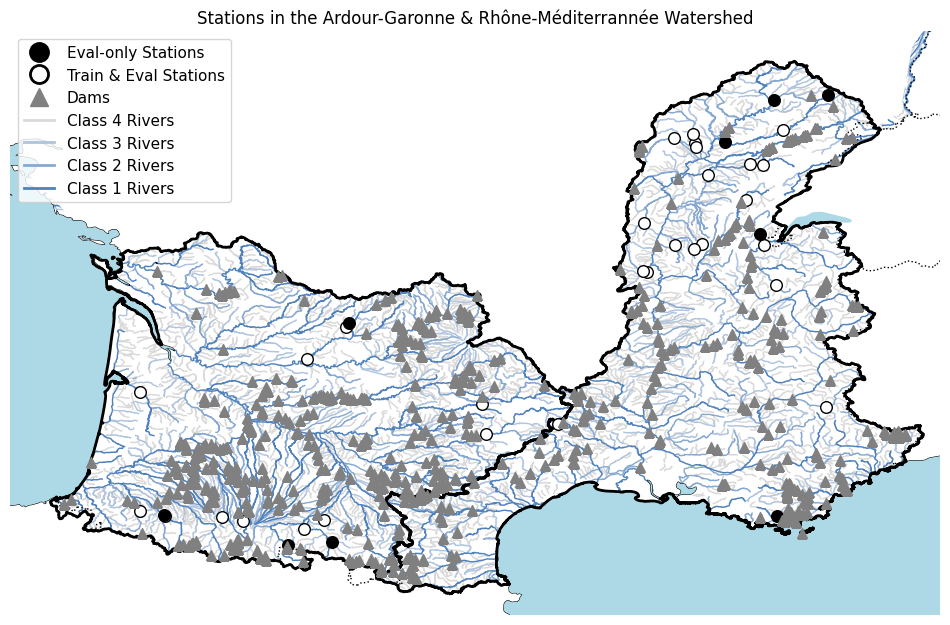

In [7]:
BBOX = [-2.3, 7.9, 42.1, 48.5]
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(BBOX, crs=ccrs.PlateCarree())

# filter rivers in the Rio Doce watershed
rivers_gdf = watercourse_df.to_crs("EPSG:4326")

# Ensure CRS matches (if garonneRhone_features is not in EPSG:4326, reproject)
garonne_rhone_geometry_df = garonne_rhone_geometry_df.to_crs(rivers_gdf.crs)

# only take class 1 rivers
rivers_gdf1 = rivers_gdf[rivers_gdf["Classe"]==1]
rivers_gdf2 = rivers_gdf[rivers_gdf["Classe"]==2]
rivers_gdf3 = rivers_gdf[rivers_gdf["Classe"]==3]
rivers_gdf4 = rivers_gdf[rivers_gdf["Classe"]==4]

# Add Base Features
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=1, zorder=7)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=7)
#ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5, zorder=7)
ax.add_feature(cfeature.LAKES, facecolor='lightblue', zorder=7)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=7)

# Plot Garonne Rhône Watersheds Polygon
garonne_rhone_geometry_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, transform=ccrs.PlateCarree(),zorder=8)

# Get france boundary
france_boundary = world[world["SOVEREIGNT"]=="France"]
outside_garonne_rhone = gpd.overlay(france_boundary, garonne_rhone_geometry_df, how='difference')

# Plot all stations in the watershed
station_train_df.plot(ax=ax, marker='o', facecolor='white', edgecolor="black", markersize=70, transform=ccrs.PlateCarree(), zorder=8)
station_test_df.plot(ax=ax, marker='o', color='black', markersize=70, transform=ccrs.PlateCarree(), zorder=8)

# Plot barrages
barrages_df.plot(ax=ax, marker='^', color='grey', markersize=50, transform=ccrs.PlateCarree(), zorder=9)
river_colors = ['#d9d9d9', '#b0c4de', '#87a9d1', '#4f81bd']  # Hex codes for gradient shades

rivers_gdf4.plot(ax=ax, edgecolor=river_colors[0], linewidth=1, transform=ccrs.PlateCarree(), zorder=-2)
rivers_gdf3.plot(ax=ax, edgecolor=river_colors[1], linewidth=1, transform=ccrs.PlateCarree(), zorder=-1)
rivers_gdf2.plot(ax=ax, edgecolor=river_colors[2], linewidth=1, transform=ccrs.PlateCarree(), zorder=0)
rivers_gdf1.plot(ax=ax, edgecolor=river_colors[3], linewidth=1, transform=ccrs.PlateCarree(), zorder=1)
outside_garonne_rhone.plot(ax=ax, facecolor='white', edgecolor='none', transform=ccrs.PlateCarree(), zorder=2)

# Define legend
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='Eval-only Stations',
           markerfacecolor='black', markersize=13, linestyle='None', markeredgewidth=2, zorder=12),
    Line2D([0], [0], marker='o', color='black', label='Train & Eval Stations',
           markerfacecolor='white', markersize=13, linestyle='None', markeredgewidth=2, zorder=12),
    # Line2D([0], [0], marker='x', color='grey', label='Other Stations',
    #        markerfacecolor='None', markersize=13, linestyle='None', zorder=12),
    Line2D([0], [0], marker='^', color='grey', label='Dams',
           markerfacecolor='grey', markersize=13, linestyle='None', zorder=12),
    Line2D([0], [0], color=river_colors[0], lw=2, label='Class 4 Rivers'),
    Line2D([0], [0], color=river_colors[1], lw=2, label='Class 3 Rivers'),
    Line2D([0], [0], color=river_colors[2], lw=2, label='Class 2 Rivers'),
    Line2D([0], [0], color=river_colors[3], lw=2, label='Class 1 Rivers')
]

# Add Title and legend
legend = plt.legend(handles=legend_elements, loc='upper left', fontsize=11)
legend.set_zorder(9)
ax.set_title('Stations in the Ardour-Garonne & Rhône-Méditerrannée Watershed')
ax.set_axis_off()
plt.show()

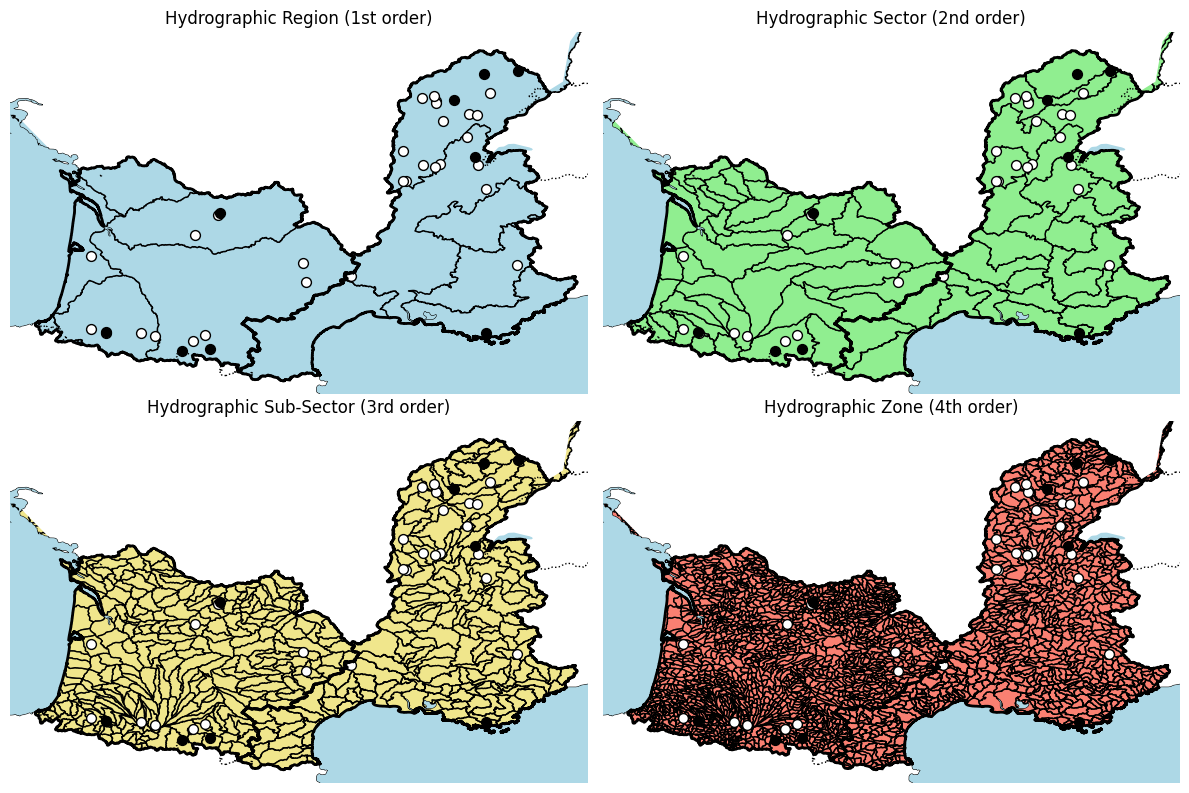

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# filter rivers in the Rio Doce watershed
hydro_level1_df = hydro_level1_df.to_crs("EPSG:4326")
hydro_level2_df = hydro_level2_df.to_crs("EPSG:4326")
hydro_level3_df = hydro_level3_df.to_crs("EPSG:4326")
hydro_level4_df = hydro_level4_df.to_crs("EPSG:4326")

# Ensure CRS matches (if garonneRhone_features is not in EPSG:4326, reproject)
garonne_rhone_geometry_df = garonne_rhone_geometry_df.to_crs(rivers_gdf.crs)

# Get brazil boundary
france_boundary = world[world["SOVEREIGNT"]=="France"]
outside_garonne_rhone = gpd.overlay(france_boundary, garonne_rhone_geometry_df, how='difference')

hydro_levels_df = [hydro_level1_df, hydro_level2_df, hydro_level3_df, hydro_level4_df]
titles = [
    "Hydrographic Region (1st order)", 
    "Hydrographic Sector (2nd order)", 
    "Hydrographic Sub-Sector (3rd order)", 
    "Hydrographic Zone (4th order)"
]
colors = ["lightblue", "lightgreen", "khaki", "salmon"]

for ax, hydro_level_df, title, color in zip(axes.flat, hydro_levels_df, titles, colors): 
    # Add Base Features
    ax.set_extent(BBOX, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=1, zorder=7)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=7)
    #ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5, zorder=7)
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', zorder=7)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=7)

    # Plot Rio Doce Watershed Polygon
    garonne_rhone_geometry_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, transform=ccrs.PlateCarree(),zorder=9)

    # # Plot all stations in the watershed
    station_train_df.plot(ax=ax, marker='o', facecolor='white', edgecolor="black", markersize=50, transform=ccrs.PlateCarree(), zorder=8)
    station_test_df.plot(ax=ax, marker='o', color='black', markersize=50, transform=ccrs.PlateCarree(), zorder=8)

    hydro_level_df.plot(ax=ax, color=color, edgecolor="black", linewidth=1, transform=ccrs.PlateCarree(), zorder=2)
    outside_garonne_rhone.plot(ax=ax, facecolor='white', edgecolor='none', transform=ccrs.PlateCarree(), zorder=6)

    # Add Title and remove axis
    ax.set_title(f'{title}')
    ax.set_axis_off()
plt.tight_layout()
plt.show()

#### II.b. Soil

In [9]:
bdod_da = soil_df[f'{country}_bdod_0-5cm_mean']
cfvo_da = soil_df[f'{country}_cfvo_0-5cm_mean']
clay_da = soil_df[f'{country}_clay_0-5cm_mean']
sand_da = soil_df[f'{country}_sand_0-5cm_mean']

In [10]:
# # For France
watershed_df = watershed_df[watershed_df["LbBH"].str.contains("Rhône-Méditerranée|Adour-Garonne", case=False, na=False)]

# Ensure CRS matches (if garonneRhone_features is not in EPSG:4326, reproject)
watershed_df = watershed_df.to_crs(bdod_da.rio.crs)

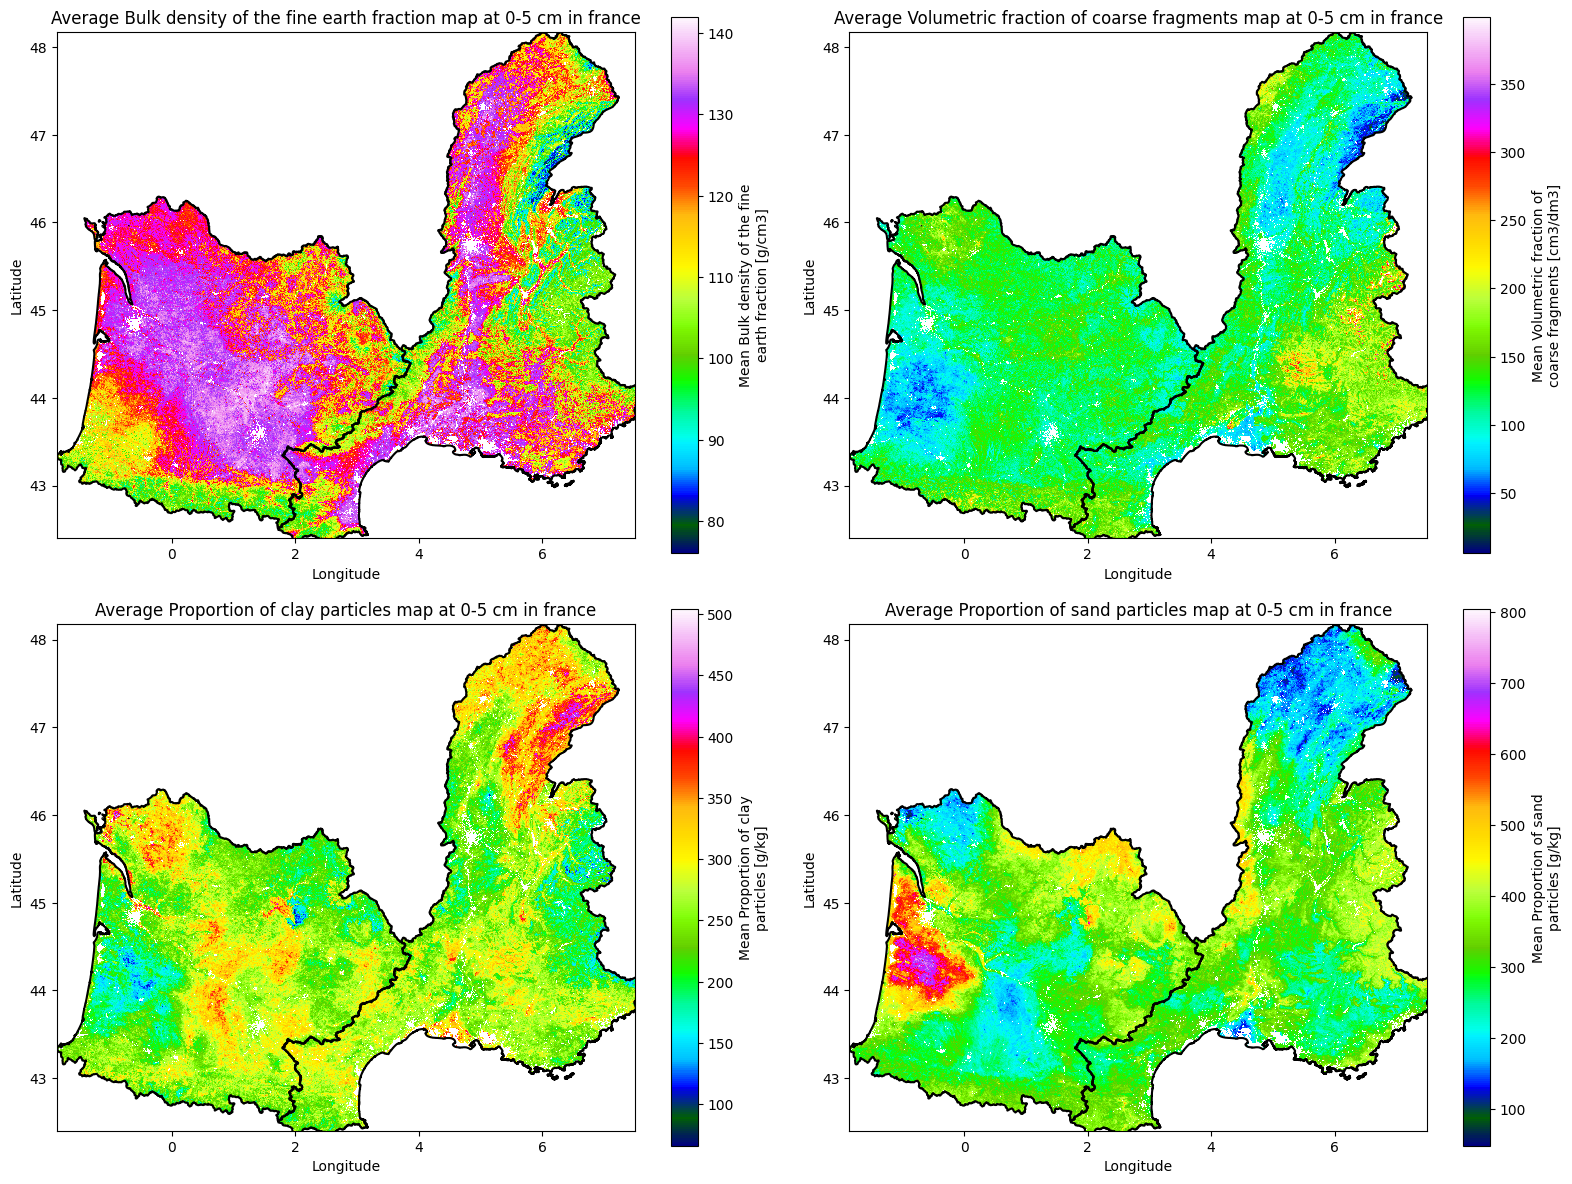

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
maps = [bdod_da, cfvo_da, clay_da, sand_da]
titles = [
    "Bulk density of the fine earth fraction", 
    "Volumetric fraction of coarse fragments", 
    "Proportion of clay particles", 
    "Proportion of sand particles"
]
for ax, data, title in zip(axes.flat, maps, titles):
    # Mask raster data outside the multipolygon
    masked_data = data.rio.clip(watershed_df.geometry, all_touched=True, drop=True)

    # Plot the masked raster with NaN values appearing white
    masked_data.plot(ax=ax, cmap='gist_ncar', add_colorbar=True)

    # Overlay multipolygon borders in black
    watershed_df.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

    # data.plot(ax=ax, cmap='gist_ncar')  # Use the same plotting function
    # watershed_df.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)  # Overlay multipolygon borders
    ax.set_title(f"Average {title} map at 0-5 cm in {country}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### III. Temporal Analysis

In [12]:
def plot_map_discharge(waterflow_df, station_train_df, year=1990):
    waterflow_df["date"] = pd.to_datetime(waterflow_df["date"])
    waterflow_df = waterflow_df[waterflow_df["date"].dt.year == year]
    waterflow_df = waterflow_df.groupby(["station_code", pd.Grouper(key="date", freq="YE")]).agg({"discharge": "mean"}).reset_index()
    merged_df = waterflow_df.merge(station_train_df, on="station_code", how="inner")
    return merged_df

In [13]:
merged_df = plot_map_discharge(waterflow_df, station_train_df, year=1990)
merged_df = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df["longitude"], merged_df["latitude"]))

In [14]:
def plot_seasonality_by_station(dataset_baseline, max_stations=50):
    """
    Plots the average monthly water flow for each station to explore seasonality.

    Args:
        dataset_baseline (pd.DataFrame): The dataset containing water flow data.
        max_stations (int): Maximum number of stations to plot.

    Returns:
        None. Saves the plots as PNG files in the specified directory.
    """
    # Ensure 'date' is in datetime format
    dataset_baseline = dataset_baseline.reset_index()
    dataset_baseline['date'] = pd.to_datetime(dataset_baseline['date'])

    # Extract the month from the observation date
    dataset_baseline['Month'] = dataset_baseline['date'].dt.month

    # Group data by station and month to calculate average water flow
    monthly_avg_flow = (
        dataset_baseline.groupby(['station_code', 'Month'])['discharge']
        .mean()
        .reset_index()
    )

    # Get the list of unique station names
    unique_names = dataset_baseline['station_code'].unique()

    # Set up the figure and subplots
    nb_fig = min(len(unique_names), max_stations)
    fig, axes = plt.subplots(nb_fig, 1, figsize=(15, 5 * nb_fig), sharex=False)
    if nb_fig == 1:  # Handle the case where there's only one station
        axes = [axes]

    # Rhone_color = "skyblue"
    # Garonne_color = "orange"

    # Create a plot for each station
    i_station = 0
    for ax, name in zip(axes, unique_names):
        if i_station < max_stations:
            # Filter data for the current station
            station_data = monthly_avg_flow[monthly_avg_flow['station_code'] == name]
            # ocolor = Rhone_color if "Rhone" in name else Garonne_color
            # Plot average water flow by month
            ax.bar(
                station_data['Month'],
                station_data['discharge'],
                color="skyblue",
                edgecolor='black'
            )

            # Customize the plot
            ax.set_title(f'Seasonality of Water Flow for Station: {name}')
            ax.set_xlabel('Month')
            ax.set_ylabel('Average Water Flow (m³/s)')
            ax.set_xticks(range(1, 13))
            ax.set_xticklabels(
                ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            )
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            i_station += 1

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Save the figure
    # current_date = pd.Timestamp.now().strftime('%d-%m-%Y_%H-%M')
    # save_path = f'../../../figures/data/{current_date}_seasonality_stations.png'
    #fig.savefig(save_path)
    
    # Optionally, close the figure to free up memory
    #plt.close(fig)

    # print(f"Seasonality plots saved to {save_path}")


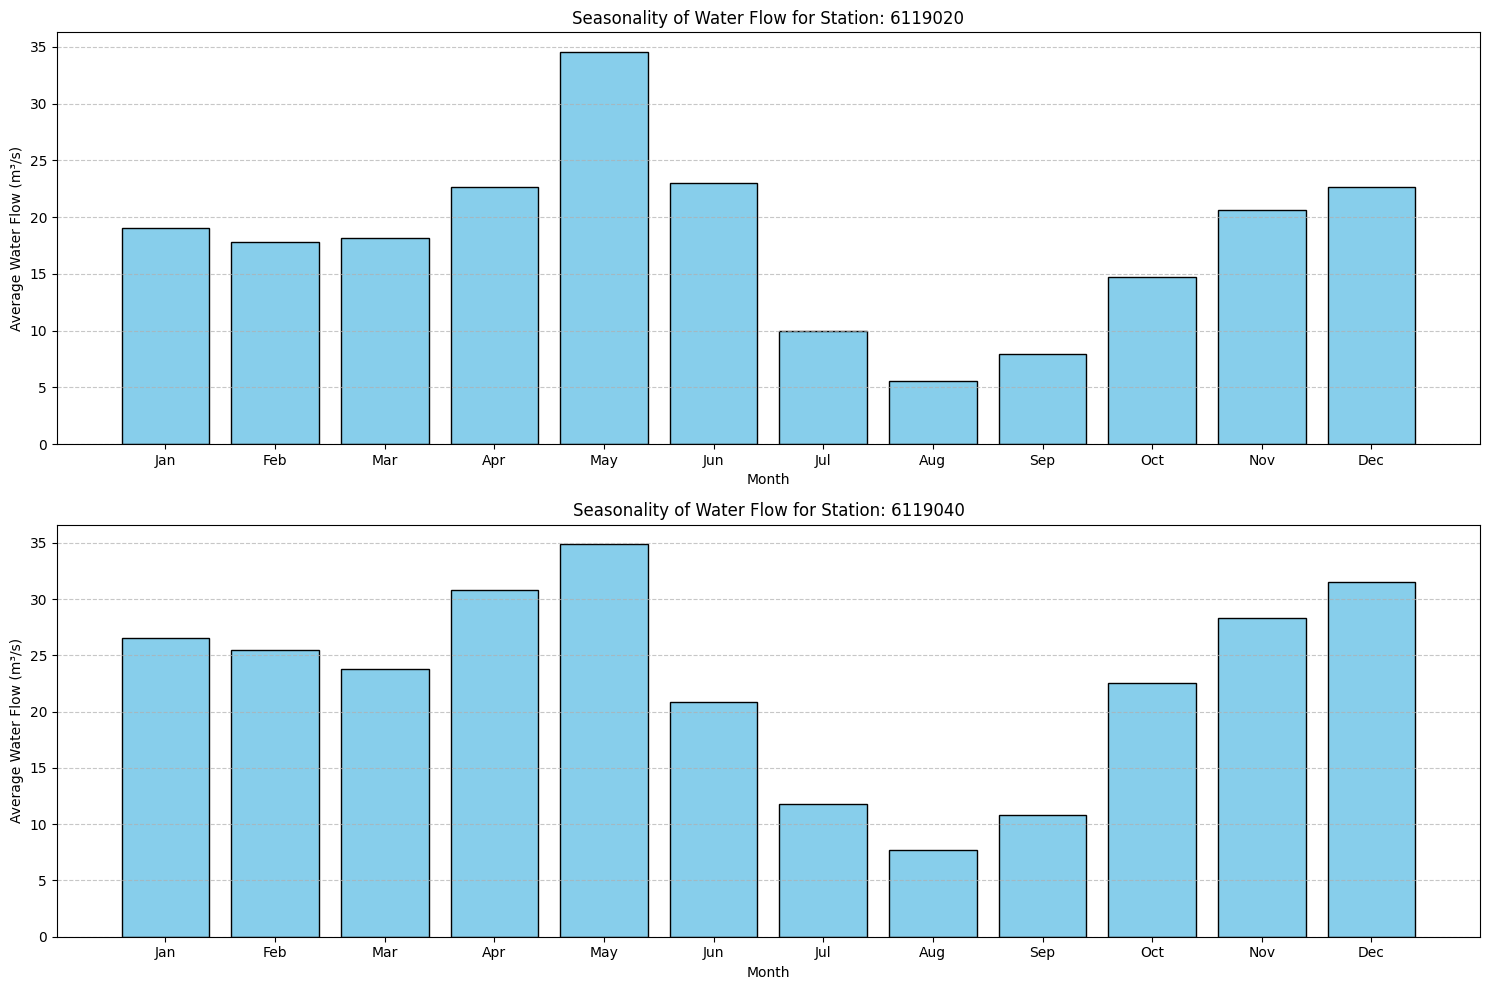

In [15]:
plot_seasonality_by_station(waterflow_df, max_stations=2)